Let's import packages and import data.

In [1]:
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns 
sns.set_context('talk')
sns.set_style('darkgrid')

import re
import scipy
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv('forecasting_train.csv')
test_df = pd.read_excel('forecasting_test.xlsx')

not_building_cols = train_df.columns[0:3]
bldg_df = train_df.drop(not_building_cols, axis=1)

1 (a)

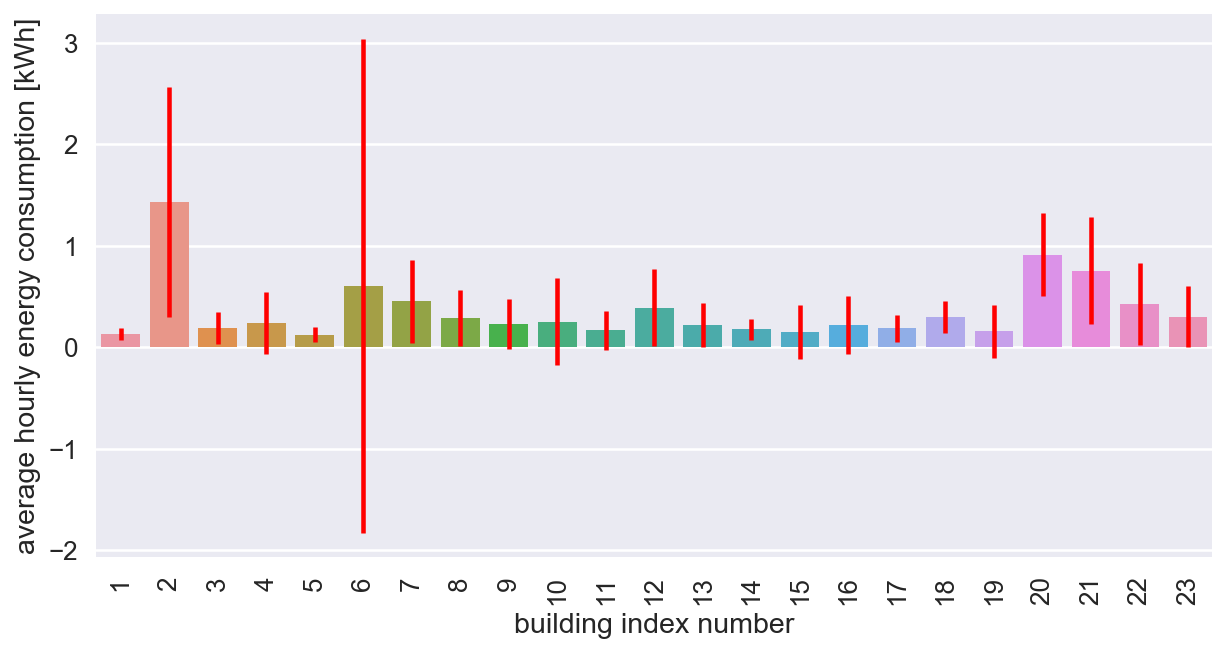

In [3]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=bldg_df,
                 estimator=np.mean,
                 ci=None)
bldg_idxs = [re.findall('\d+', str(s))[-1] for s in ax.get_xticklabels()]
ax.set_xticklabels(bldg_idxs, rotation=90)
ax.errorbar(bldg_idxs, bldg_df.mean(), yerr=bldg_df.std(), ecolor='r', ls='None')
ax.set_xlabel('building index number')
ax.set_ylabel('average hourly energy consumption [kWh]')
plt.show()

1 (b)

In [4]:
# High variance buildings
bldg_df.var().sort_values(ascending=False).head()

Bldg6 (kWh)     5.923278
Bldg2 (kWh)     1.281581
Bldg21 (kWh)    0.276375
Bldg10 (kWh)    0.180200
Bldg7 (kWh)     0.167332
dtype: float64

In [5]:
# We can use the f test to see how different the variance of Bldg 6 is in comparison to the others
def f_test(X, Y):
    # Returns the p value, the probability of a difference in variances as extreme as the observed difference if the null hypothesis is true
    f_stat = np.var(X) / np.var(Y)
    degs_free_1 = len(X) - 1
    degs_free_2 = len(Y) - 1
    return 1 - scipy.stats.f.cdf(f_stat, degs_free_1, degs_free_2)

In [6]:
col_to_compare = 'Bldg6 (kWh)'
print('p values')
for col in bldg_df.columns:
    print('{} vs {}: {}'.format(col_to_compare,
                                col,
                                f_test(bldg_df[col_to_compare], bldg_df[col])))

p values
Bldg6 (kWh) vs Bldg1 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg2 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg3 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg4 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg5 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg6 (kWh): 0.4999999999985263
Bldg6 (kWh) vs Bldg7 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg8 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg9 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg10 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg11 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg12 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg13 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg14 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg15 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg16 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg17 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg18 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs Bldg19 (kWh): 1.1102230246251565e-16
Bldg6 (kWh) vs B

In [7]:
# Check if any buildings have moments of negative power consumption
for col in bldg_df.columns:
    if (bldg_df[col] < 0).any():
        print(col)

Bldg6 (kWh)


In [8]:
# Let's drop it from our analysis
bldg_df.drop('Bldg6 (kWh)', axis=1, inplace=True)
bldgs = bldg_df.columns

1 (c)

In [9]:
# Normalize
bldg_df = bldg_df / bldg_df.max()

date_series = pd.to_datetime(train_df['UNIX Timestamp (seconds)'], unit='s')
# New columns for date info
bldg_df = bldg_df.assign(day_of_week=date_series.dt.dayofweek)
bldg_df = bldg_df.assign(week_of_year=date_series.dt.week)
bldg_df = bldg_df.assign(hour_of_day=date_series.dt.hour)

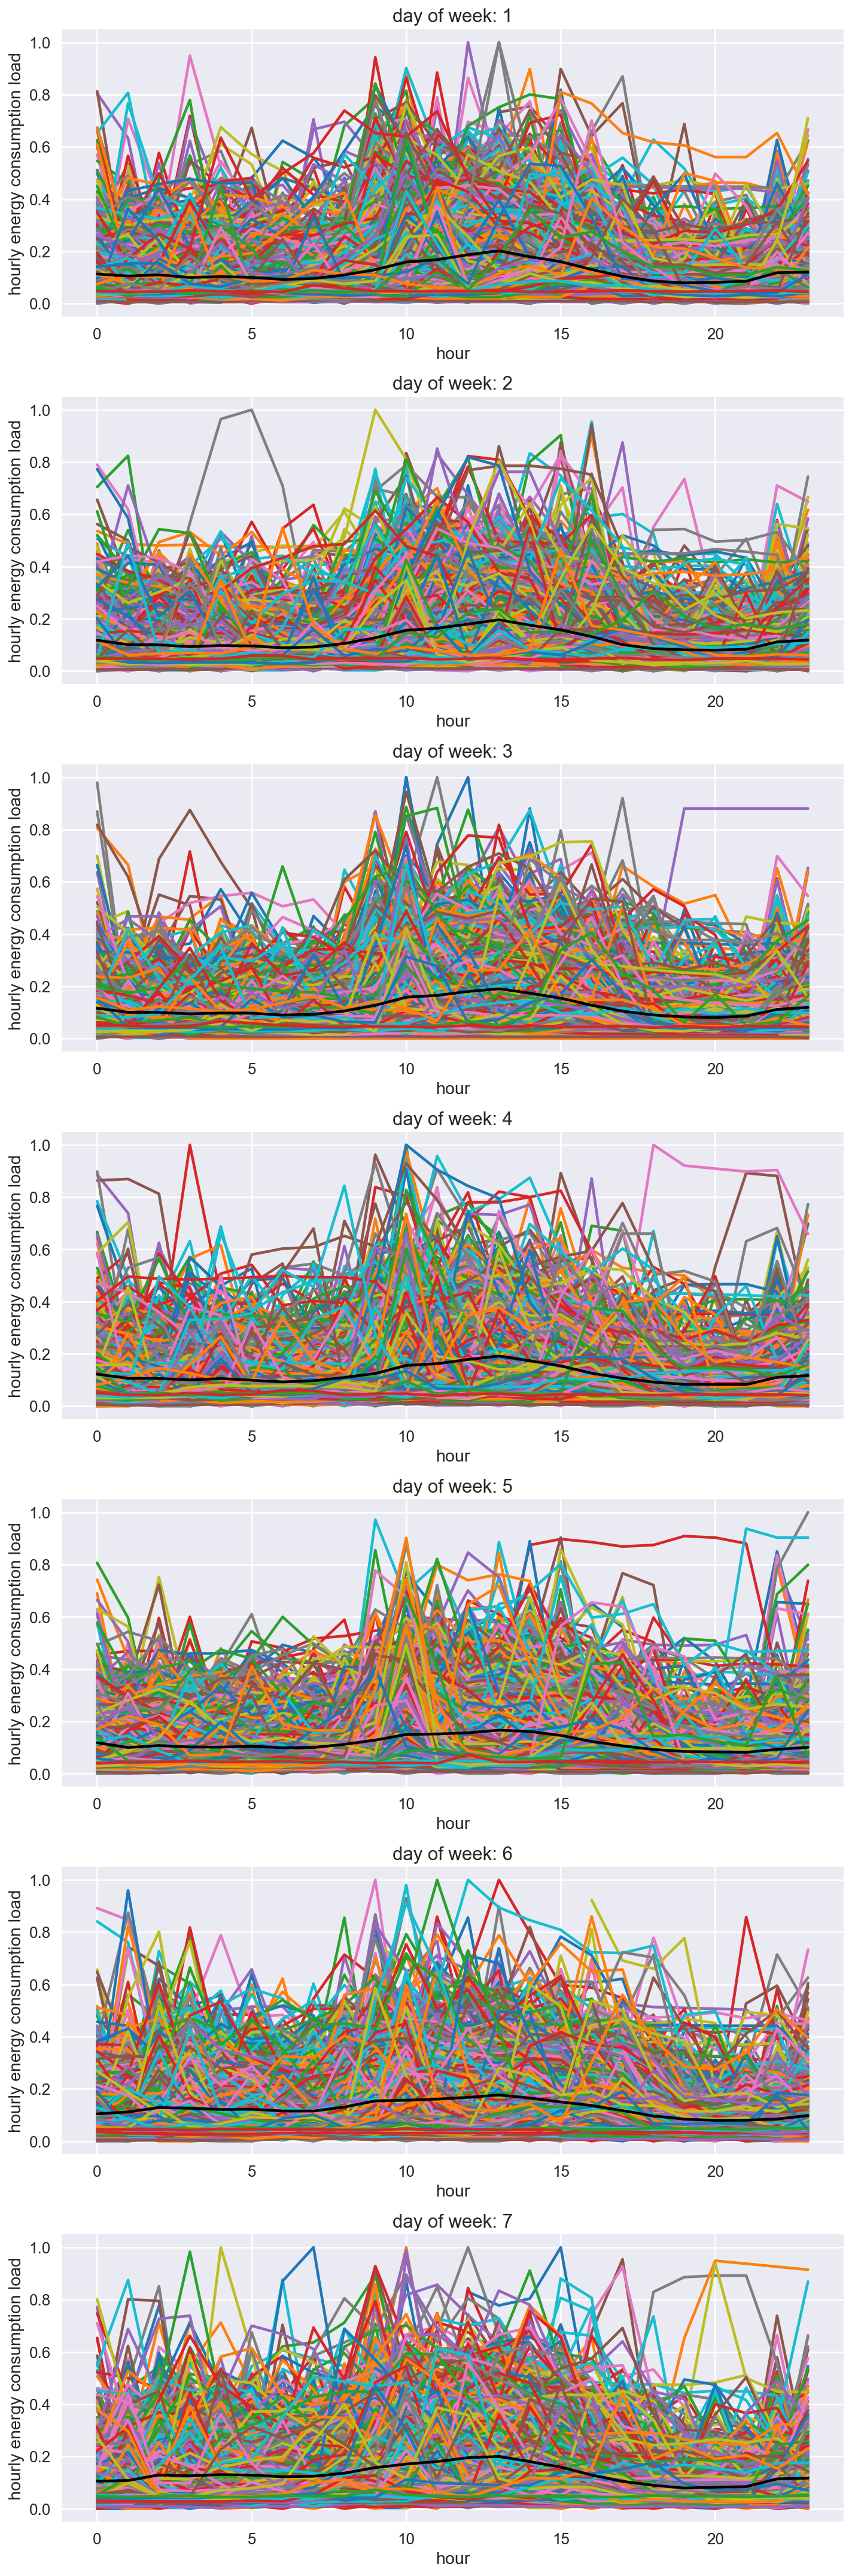

In [10]:
plt.figure(figsize=(10, 30))
for dow in sorted(bldg_df.day_of_week.unique()):
    plt.subplot(7, 1, dow + 1)
    for bldg in bldgs:
        for woy in bldg_df.week_of_year.unique():
            day_df = bldg_df[(bldg_df.week_of_year == woy) & (bldg_df.day_of_week == dow)]
            plt.plot(day_df['hour_of_day'], day_df[bldg])
    plt.plot(bldg_df[bldg_df.day_of_week == dow].drop(
        ['day_of_week', 'week_of_year'], axis=1
    ).groupby('hour_of_day').mean().T.mean(), color='black')
    plt.xlabel('hour')
    plt.ylabel('hourly energy consumption load')
    plt.title('day of week: {}'.format(dow + 1))
plt.tight_layout()
plt.show()

2 (a)

In [11]:
test_df = test_df.assign(day_of_week=test_df['TestTime'].dt.dayofweek)
test_df = test_df.assign(hour_of_day=test_df['TestTime'].dt.hour)

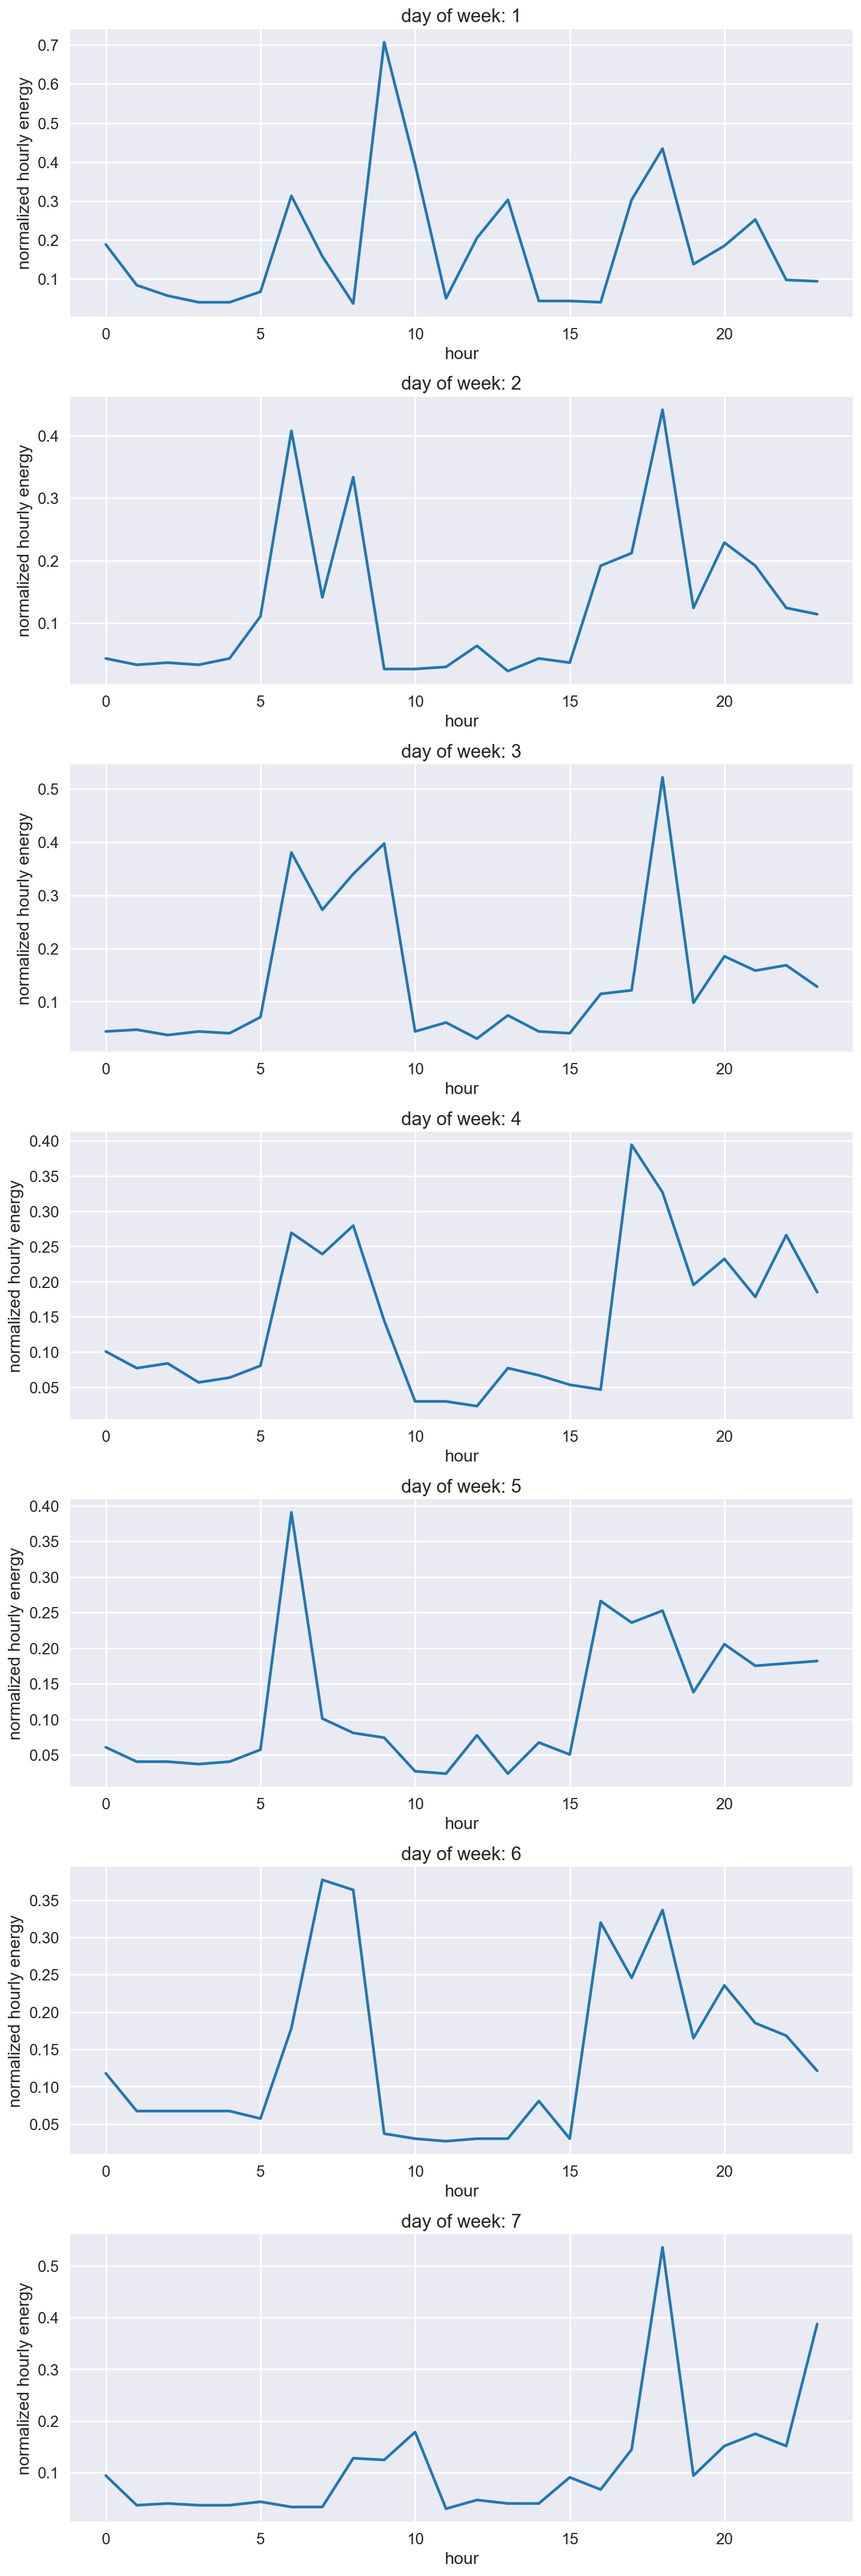

In [17]:
plt.figure(figsize=(10, 30))
for dow in sorted(test_df.day_of_week.unique()):
    plt.subplot(7, 1, dow + 1)
    day_df = test_df[test_df.day_of_week == dow]
    plt.plot(day_df.hour_of_day, day_df.TestBldg)
    plt.xlabel('hour')
    plt.ylabel('normalized hourly energy')
    plt.title('day of week: {}'.format(dow + 1))
plt.tight_layout()
plt.show()

In [13]:
test_df.groupby('day_of_week', as_index=False).TestBldg.mean()

day_of_week  TestBldg
0            0  0.178311
1            1  0.127806
2            2  0.144220
3            3  0.146044
4            4  0.117705
5            5  0.141975
6            6  0.114338

In [14]:
test_df = test_df.merge(
    test_df.groupby('day_of_week', as_index=False).TestBldg.mean(),
    on='day_of_week',
    suffixes=('','_dow_mean'))

In [23]:
# MAE for DoW
test_df.assign(
    abs_errors=np.abs(test_df.TestBldg_dow_mean - test_df.TestBldg)
).groupby(
    'day_of_week',
    as_index=False
).agg(
    {'abs_errors': 'mean'}
)

day_of_week  abs_errors
0            0    0.125257
1            1    0.093808
2            2    0.105874
3            3    0.092102
4            4    0.080352
5            5    0.096334
6            6    0.078949

In [24]:
# MAE for week
test_df.assign(
    abs_errors=np.abs(test_df.TestBldg.mean() - test_df.TestBldg)
).agg(
    {'abs_errors': 'mean'}
)

abs_errors    0.097368
dtype: float64

3 (a)

$$Y = \begin{bmatrix} \hat{P}_{arx}(k) \end{bmatrix}$$

$$\Phi = \begin{bmatrix} \alpha_{1} & \alpha_{2} & ... & \alpha_{k - 1} & \alpha_{k}\end{bmatrix} $$

$$\theta = \begin{bmatrix} P(1) \\ P(2) \\ ... \\ P(k-1) \\ P(k)\end{bmatrix}$$

3 (b)

$$
J = \frac{1}{2} \sum_{k=1}^{m} \left[ P(k) - \hat{P}_{arx}(k)\right]^{2} \\
= \frac{1}{2} \sum_{k=1}^{m} \left[ P(k) - \sum_{\ell=1}^{L} \alpha_{\ell} P(k - \ell) + \hat{P}_{avg}(k) \right]^{2} \\
= \frac{1}{2} \sum_{k=1}^{m} \left[ \left(P(k) + \hat{P}_{avg}(k)\right) - \sum_{\ell=1}^{L} \alpha_{\ell} P(k - \ell) \right]^{2} \\
= \frac{1}{2} \sum_{k=1}^{m} \left[ \left(P(k) + \hat{P}_{avg}(k)\right)^{2} - \left(P(k) + \hat{P}_{avg}(k)\right)\left(\sum_{\ell=1}^{L} \alpha_{\ell} P(k - \ell) \right) + \left(\sum_{\ell=1}^{L} \alpha_{\ell} P(k - \ell) \right)^{2} \right] \\
= \frac{1}{2} \sum_{k=1}^{m} \left[ \left(P(k) + \hat{P}_{avg}(k)\right)^{2} - \left(P(k) + \hat{P}_{avg}(k)\right) \Phi \theta + \left(\Phi \theta \right)^{2} \right]
$$

Yes, this is a convex problem because the second derivative is always positive (because each of the input terms get squared in $\theta^{T} \theta$).

$$
\frac{\partial J}{\partial \Phi} = \frac{1}{2} \sum_{k=1}^{m} \left[- \left(P(k) + \hat{P}_{avg}(k)\right) \theta + 2 \Phi^{T} \theta^{T} \theta \right]
$$

$$
\frac{\partial^{2} J}{\partial \Phi \partial \Phi^{T}} = \sum_{k=1}^{m} \theta^{T} \theta
$$

3 (c)



Skipping to the neural network part because that's more interesting.